# Gaussian Process Regression

Numpy implementation of gaussian process regression,
reference from [krasserm](http://krasserm.github.io/2018/03/19/gaussian-processes/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
rng = np.random.RandomState(0)
X_plot = np.linspace(0, 30, 200).reshape(-1,1)
# X_plot = np.sort(30 * rng.rand(1100, 1), axis=0)
X_train = np.sort(15 * rng.rand(100, 1), axis=0)
Y_train = np.sin(X_train).ravel()
Y_train_noisy = Y_train + 1 * (0.5 - rng.rand(X_train.shape[0]))

In [3]:
def plot_gp(mu, cov, X, samples=[]):
    X = X.reshape(-1)
    mu = mu.reshape(-1)

    # 95% confidence interval
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')

    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label='sample_{}'.format(i))

    plt.legend()

In [42]:
def plot_kernel(kernel_, x=X_plot):
    K_plot = kernel_(x,x)
    plt.imshow(K_plot)
    _ = plt.xticks(np.arange(0,x.shape[0], 15),x[::15,0].astype(np.int))
    _ = plt.yticks(np.arange(0,x.shape[0], 15),x[::15,0].astype(np.int))
    plt.colorbar()

In [5]:
def plot_nn(pred, X, samples=[]):
    plt.plot(X, pred, label='Prediction')
    plt.legend()

## 1. Kernel definition


Linear Kernel: $k(x_1,x_2) =\sigma_b^2 + \sigma_v^2 (x_1 - c)(x_2-c)$

In [6]:
def linear(x1, x2, sigma_b=1, sigma_v=1, c=0, **kwargs):
    return sigma_b**2 + sigma_v**2 * np.inner(x1-c, x2-c)

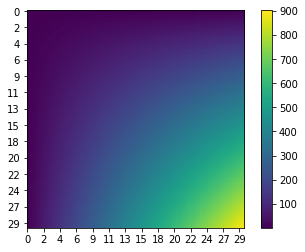

In [7]:
plot_kernel(linear)

RBF Kernel: $k(x_1,x_2) =\sigma^2 \exp\left( - \frac{||x_1-x_2||^2}{2l^2} \right)$

In [8]:
def rbf(x1, x2, l=1, sigma_f=1, **kwargs):
    dists = cdist(x1 / l, x2 / l, metric='sqeuclidean')
    return sigma_f**2 * np.exp(-.5 * dists)

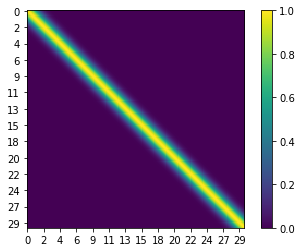

In [9]:
plot_kernel(rbf)

Periodic Kernel: $k(x_1,x_2) =\sigma^2 \exp\left( - \frac{2\sin^2(\pi|x_1-x_2|/p)}{l^2} \right)$

In [10]:
def periodic(x1, x2, l=1.0, sigma_f=1.0, p=5.0, **kwargs):
    dists = cdist(x1, x2, metric='euclidean')
    return sigma_f**2 * np.exp(- 2 * (np.sin(np.pi / p * dists)/ l) ** 2)

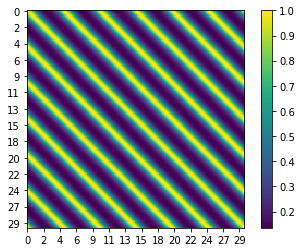

In [11]:
plot_kernel(periodic)

Locally Periodic Kernel: $k(x_1,x_2) =\sigma^2 \exp\left( - \frac{2\sin^2(\pi|x_1-x_2|/p)}{l^2} \right) \exp\left(-\frac{||x_1-x_2||^2}{2l^2}\right)$

In [12]:
def locally_periodic(x1, x2, l=1, sigma_f=0.5, p=2.0):
    return periodic(x1,x2, l, sigma_f, p) * rbf(x1,x2,l,sigma_f) / sigma_f**2

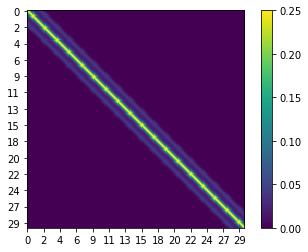

In [13]:
plot_kernel(locally_periodic)

White Noise Kernel: $k(x_1,x_2) = \sigma^2 \cdot I_n$

In [14]:
def white_noise(x1,x2, sigma=0.1, **kwargs):
    if x1 is x2:
        return sigma**2 * np.eye(len(x1))
    else:
        return np.zeros((len(x1), len(x2))) 

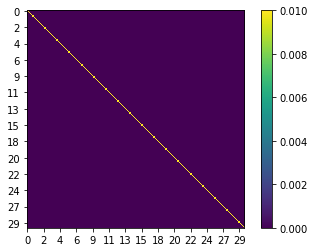

In [15]:
plot_kernel(white_noise)

In [16]:
def add_white_noise(kernel):
    return lambda x1,x2, sigma=0.0, **opts: white_noise(x1,x2,sigma) + kernel(x1,x2,**opts)

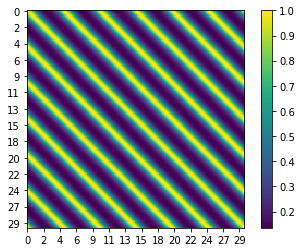

In [17]:
kernel = add_white_noise(periodic)
plot_kernel(kernel)

## 2. Define prior

Zero mean, covariance from kernel

In [18]:
mu = np.zeros(X_plot.shape)
cov = kernel(X_plot, X_plot, sigma=0.1)

# sampling functions from multivariate normal distributio
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 3)

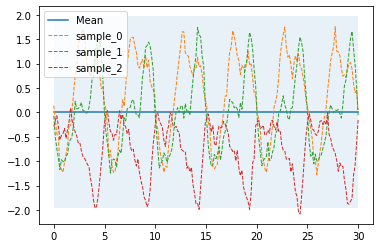

In [19]:
plot_gp(mu, cov, X_plot, samples)

### Inverted cov matrix prior

In [20]:
cov_inv = np.linalg.inv(cov)

# sampling functions from multivariate normal distributio
samples = np.random.multivariate_normal(mu.reshape(-1), cov_inv, 3)

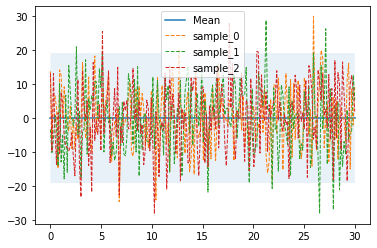

In [21]:
plot_gp(mu, cov_inv, X_plot, samples)

## 3. Compute posterior

Compute posterior with gaussian process regression

In [64]:
def posterior_predictive(X, X_train, Y_train, kernel_=kernel, **opts):
    K = kernel_(X_train, X_train, **opts)
    K_s = kernel_(X_train, X, **opts)
    K_ss = kernel_(X, X, **opts)

    K_inv = np.linalg.inv(K)

    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s

In [23]:
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train)
samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)

<ipython-input-23-8edf89b764cb>:2: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)


<ipython-input-3-cdd923161051>:6: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


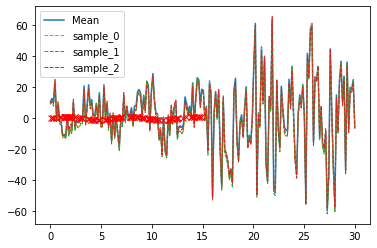

In [24]:
plot_gp(mu_s, cov_s, X_plot, samples)
plt.plot(X_train, Y_train, 'rx')

## 4. Training data with noise

Assume training data has noise with zero mean and 0.3 stddev

In [25]:
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train_noisy)
samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)

<ipython-input-25-869ab4706439>:2: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)


<ipython-input-3-cdd923161051>:6: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


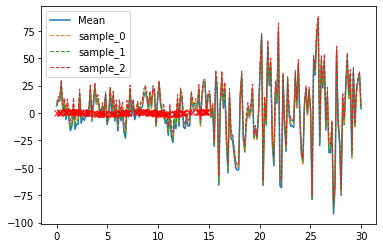

In [26]:
plot_gp(mu_s, cov_s, X_plot, samples)
plt.plot(X_train, Y_train_noisy, 'rx')

## 5. GPR with several parameters

Simulate gaussian process regression with several parameters

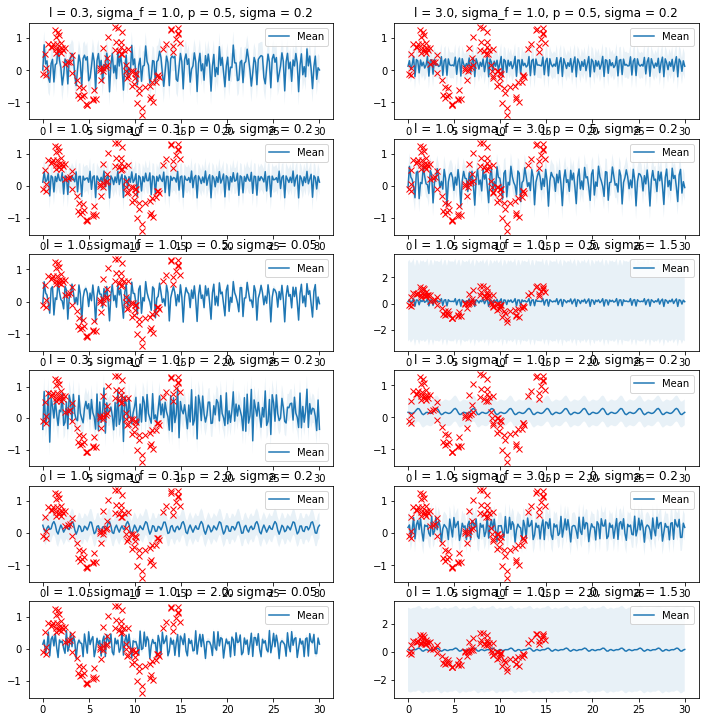

In [27]:
params = [
    (0.3, 1.0, 0.2,0.5),
    (3.0, 1.0, 0.2,0.5),
    (1.0, 0.3, 0.2,0.5),
    (1.0, 3.0, 0.2,0.5),
    (1.0, 1.0, 0.05,0.5),
    (1.0, 1.0, 1.5,0.5),
    (0.3, 1.0, 0.2,2.0),
    (3.0, 1.0, 0.2,2.0),
    (1.0, 0.3, 0.2,2.0),
    (1.0, 3.0, 0.2,2.0),
    (1.0, 1.0, 0.05,2.0),
    (1.0, 1.0, 1.5,2.0),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma,p) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train_noisy, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma=sigma,
                                       p=p)
    plt.subplot(6, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, p = {p}, sigma = {sigma}')
    plot_gp(mu_s, cov_s, X_plot)
    plt.plot(X_train, Y_train_noisy, 'rx')

## 6. Optimize hyper parameters with gradient based algorithm

Optimize parameters to maximize liklihood of posterior predictive.

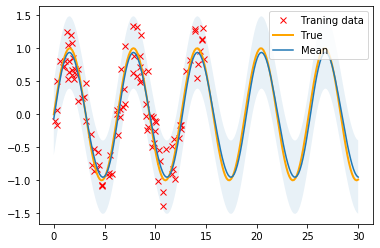

In [28]:
from scipy.optimize import minimize
from functools import partial

# -log liklihood
def nll_fn(X_train, Y_train):
    def step(theta):
        K = kernel(X_train, X_train, sigma=theta[0], l=theta[1], sigma_f=theta[2], p=theta[3])
        return np.sum(np.log(np.diagonal(np.linalg.cholesky(K)))) + \
               0.5 * Y_train.T @ np.linalg.inv(K) @ Y_train + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

# minimize -log liklihood
res = minimize(nll_fn(X_train, Y_train_noisy), [0.01, 1, 1, 5.0], 
               bounds=((1e-5, 1e1),(1e-5, None), (1e-5, None), (1e-2, 1e1)),
               method='L-BFGS-B')

sigma_opt, l_opt, sigma_f_opt, p_opt = res.x
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train_noisy, l=l_opt, sigma_f=sigma_f_opt, p=p_opt, sigma=sigma_opt)
plt.plot(X_train, Y_train_noisy, 'rx', label="Traning data")
plt.plot(X_plot, np.sin(X_plot), color='orange', lw=2, label='True')
plot_gp(mu_s, cov_s, X_plot)
fig1 = plt.gcf()

fitted_kernel = partial(kernel, sigma_f=sigma_f_opt, l=l_opt, sigma=sigma_opt)

In [29]:
fig1.savefig("periodic.png", dpi=200)

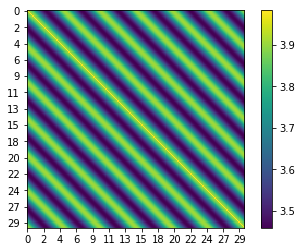

In [29]:
plot_kernel(fitted_kernel)
fig2 = plt.gcf()
fig2.savefig("periodic_kernel.png", dpi=200)

## Fitting a Neural Network

In [68]:
def compute_cov_matrix(x1, x2):
    x1_flat = x1.flatten(1, -1)
    centered1 = x1_flat #- x1_flat.mean(dim=1).view(-1, 1)
    x2_flat = x2.flatten(1, -1)
    centered2 = x2_flat #- x2_flat.mean(dim=1).view(-1, 1)
    result = (centered1 @ centered2.transpose(0, 1)) #/ torch.ger(
#         torch.norm(centered1, 2, dim=1), torch.norm(centered2, 2, dim=1)
#     )  # see https://de.mathworks.com/help/images/ref/corr2.html
    return result

def atanh(x):
    return 0.5*torch.log((1+x)/(1-x))

In [48]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio
from tqdm import tqdm
import copy
from functools import partial

torch.manual_seed(1)    # reproducible

In [94]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Sigmoid(),
        torch.nn.Linear(100, 100),
        torch.nn.Sigmoid(),
        torch.nn.Linear(100, 4),
        torch.nn.Sigmoid(),
        torch.nn.Linear(4, 1, bias=False),
    )
class SinNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1, 100)
        self.l2 = torch.nn.Linear(100, 100)
        self.l3 = torch.nn.Linear(100, 100)
        self.l4 = torch.nn.Linear(100, 1)
        
    def forward(self, x, i=3):
        x = self.l1(x)
        x = torch.sin(x)
        if i>0:
            x = self.l2(x)
            x = torch.sin(x)
        if i>1:
            x = self.l3(x)
            x = torch.sin(x)
        if i>2:
            x = self.l4(x)
        return x
    
# net = SinNet()    
device = "cuda" if torch.cuda.is_available() else "cpu"
net = net.to(device)

 49%|████▉     | 4920/10000 [45:14<46:43,  1.81it/s, eig_vec_0=[-0.9779695   0.0375652   0.07762116 -0.03894849], loss=0.191, phi_0=[0.25511852 0.17055532 0.22767839 0.36941496]] 


In [95]:
rdm_matching = False
# if rdm_matching:
#     net = net[:-1]
print(net)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=4, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=1, bias=False)
)


In [97]:
# net.load_state_dict(torch.load("best_model.pth"))
# if isinstance(net, SinNet):
#     params = []
#     params += list(net.l1.parameters())
#     params+= list(net.l2.parameters())
#     params += list(net.l3.parameters())
# else:
#     params = net.parameters()
# for param in params:
#      param.requires_grad = False

In [98]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, amsgrad=True, weight_decay=1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 32
EPOCH = 400

# if rdm_matching:
#     torch_dataset = Data.TensorDataset(torch.tensor(X_plot,dtype=torch.float),torch.tensor(X_plot,dtype=torch.float))
#     torch_dataset = Data.TensorDataset(torch.tensor(X_plot,dtype=torch.float),torch.tensor(X_plot,dtype=torch.float))
# else:
train = Data.TensorDataset(torch.tensor(X_train[:90],dtype=torch.float),torch.tensor(Y_train_noisy[:90],dtype=torch.float))
dev = Data.TensorDataset(torch.tensor(X_train[90:],dtype=torch.float),torch.tensor(Y_train_noisy[90:],dtype=torch.float))

train_loader = Data.DataLoader(
    dataset=train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)
dev_loader = Data.DataLoader(
    dataset=dev, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

In [99]:
# start training
if hasattr(
    tqdm, "_instances"
):  # To have tqdm output without line-breaks between steps
            tqdm._instances.clear()
t= tqdm(range(EPOCH))
min_dev_loss = 1000000
best_state = None
dev_step = 1
epoch_dev_loss = 0.0
for epoch in t:
    epoch_loss = 0.0
    net.train()
    for step, (batch_x, batch_y) in enumerate(train_loader): # for each training step
        
        b_x = batch_x.to(device)
        b_y = batch_y.to(device)

        if rdm_matching and not isinstance(net, torch.nn.Sequential):
            prediction = net(b_x, i=2)     # input x and predict based on x
        else:
            prediction = net(b_x)     # input x and predict based on x

        if rdm_matching:
            rdm = compute_cov_matrix(prediction, prediction)
            kernel_matrix = torch.tensor(fitted_kernel(b_x.cpu().numpy(),b_x.cpu().numpy()), dtype=torch.float).to(device)
#             loss = loss_func(torch.exp(rdm.reshape((-1))), torch.exp(kernel_matrix.reshape((-1))))    # must be (1. nn output, 2. target)
            loss = loss_func(rdm.reshape((-1)), kernel_matrix.reshape((-1)))    # must be (1. nn output, 2. target)
        else:
            loss = loss_func(prediction.reshape((-1)), b_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        epoch_loss += loss.item()
        t.set_postfix(epoch_loss=epoch_loss/(step+1), epoch_dev_loss=epoch_dev_loss/(dev_step+1))
    net.eval()
    epoch_dev_loss = 0.0
    for dev_step, (batch_x, batch_y) in enumerate(dev_loader): 
        b_x = batch_x.to(device)
        b_y = batch_y.to(device)
        if rdm_matching and not isinstance(net, torch.nn.Sequential):
            prediction = net(b_x, i=2)     # input x and predict based on x
        else:
            prediction = net(b_x)     # input x and predict based on x

        if rdm_matching:
            rdm = compute_cov_matrix(prediction, prediction)
            kernel_matrix = torch.tensor(fitted_kernel(b_x.cpu().numpy(),b_x.cpu().numpy()), dtype=torch.float).to(device)
#             loss = loss_func(torch.exp(rdm.reshape((-1))), torch.exp(kernel_matrix.reshape((-1))))    # must be (1. nn output, 2. target)
            loss = loss_func(rdm.reshape((-1)), kernel_matrix.reshape((-1)))    # must be (1. nn output, 2. target)
        else:
            loss = loss_func(prediction.reshape((-1)), b_y)     # must be (1. nn output, 2. target)

        epoch_dev_loss += loss.item()
        t.set_postfix(epoch_loss=epoch_loss/(step+1), epoch_dev_loss=epoch_dev_loss/(dev_step+1))
    if epoch_dev_loss < min_dev_loss:
        torch.save(net.state_dict(), "best_model.pth")

100%|██████████| 400/400 [02:24<00:00,  2.77it/s, epoch_dev_loss=2.23, epoch_loss=0.11]  


In [100]:
net.load_state_dict(torch.load("best_model.pth"))
net.eval()

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=4, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=1, bias=False)
)

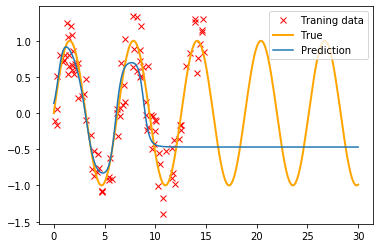

In [101]:
if not rdm_matching:
    plt.plot(X_train, Y_train_noisy, 'rx', label="Traning data")
    plt.plot(X_plot, np.sin(X_plot), color='orange', lw=2, label='True')
    prediction = net(torch.tensor(X_plot,dtype=torch.float).to(device))     # input x and predict based on x
    plot_nn(prediction.detach().cpu().numpy(), X_plot)
    fig = plt.gcf()
#     fig.savefig("sin_net_match_periodic_retrained.png", dpi=200)

## Use Network as kernel and look at corresponding GP

 62%|██████▏   | 6183/10000 [1:36:46<59:44,  1.06it/s, loss=0.309]


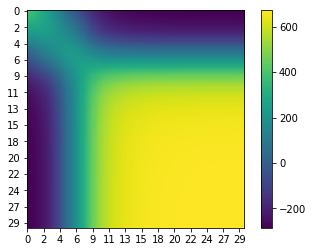

In [102]:
def nn_kernel(x1, x2, Lambda=None):
    x1 = torch.tensor(x1, dtype=torch.float).to(device)
    x2 = torch.tensor(x2, dtype=torch.float).to(device)
    if isinstance(net, torch.nn.Sequential):
        y1 = net[:5](x1).detach()
        y2 = net[:5](x2).detach()
    else:
        y1 = net(x1, i=2).detach()
        y2 = net(x2, i=2).detach()
    RSM = compute_cov_matrix(y1,y2).cpu().numpy()
    if Lambda is not None:
        RSM = RSM @ Lambda
    return RSM

plot_kernel(nn_kernel)
fig = plt.gcf()
# fig.savefig("sin_net_match_periodic_kernel.png", dpi=200)

In [103]:
def find_base_points(net):
    v = net[-1].weight.detach().T
    sigma = v @ v.T 
    eig_vals, eig_vecs = torch.eig(sigma, eigenvectors=True)
    # eig_vals (n x 2) with entries (real,imaginary) 
    # eig_vecs (n x n) where [:,j] corresponds to eig_vals[j]
    eig_vecs = eig_vecs.T
    x = Variable(15 * torch.randn(1, 1).cuda(), requires_grad=True)
    params = net.parameters()
    optim = torch.optim.Adam([x], 0.001)
    for param in params:
         param.requires_grad = False
    if hasattr(
        tqdm, "_instances"
    ):  # To have tqdm output without line-breaks between steps
                tqdm._instances.clear()
    t= tqdm(range(10000))
    net.train()
    print("X before:", x)
    for batch in t:
        y = net[:-1](x)
        loss = torch.mean((eig_vecs - y)**2)
        optim.zero_grad()
        loss.backward()
        optim.step()
        net.eval()
        phi = net[:-1](x)
        t.set_postfix(loss=loss.item(), eig_vec_0=eig_vecs[0][:4].cpu().numpy(), phi_0=phi[0][:4].detach().cpu().numpy())
        net.train()
    net.eval()
    return x.detach().cpu().numpy(), eig_vals.cpu().numpy()

base_points, eig_values = find_base_points(net) 

  0%|          | 17/10000 [00:00<00:59, 168.27it/s, eig_vec_0=[-0.83193314  0.02800588  0.2769834  -0.47998258], loss=0.36, phi_0=[5.77569139e-08 1.19652515e-02 9.57852840e-01 1.06710128e-01]] 

X before: tensor([[1.2513]], device='cuda:0', requires_grad=True)


100%|██████████| 10000/10000 [00:59<00:00, 169.20it/s, eig_vec_0=[-0.83193314  0.02800588  0.2769834  -0.47998258], loss=0.184, phi_0=[2.2393376e-09 1.9151516e-02 1.2311065e-01 3.6360987e-02]]   


In [104]:
mod_kernel = partial(nn_kernel, Lambda=np.diag(eig_values[:,0]))
plot_kernel(mod_kernel, x=base_points)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

In [72]:
base_points_pred = net(torch.tensor(base_points).to(device)).detach().cpu().numpy()

In [73]:
# Y_plot = np.array([np.sin(x) for x in X_plot])
mu_s, cov_s = posterior_predictive(base_points, base_points, base_points_pred, kernel_=mod_kernel)
# plt.plot(X_plot, Y_plot, 'rx', label="Traning data")
plot_gp(mu_s, cov_s, X_plot)
plt.plot(X_plot, np.sin(X_plot), color='orange', lw=2, label='True')
fig1 = plt.gcf()

LinAlgError: Singular matrix

## Regularize with RDM matching for K from preriodic function

In [241]:
net[:4]

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
)

## Regularize with corrected RDM matching for K from periodic function